## Installing TimeGAN

In [ ]:
!pip install ydata-synthetic==0.3.0

In [2]:
! pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.3.2
Uninstalling matplotlib-3.3.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.2
     |████████████████████████████████| 13.1 MB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-synthetic 0.3.0

## Importing libraries

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.signal import savgol_filter

## Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

## Importing clusters

In [ ]:
data_0 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster0.csv').drop(['Unnamed: 0'], axis = 1) #pd.DataFrame(cluster)
data_1 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster1.csv').drop(['Unnamed: 0'], axis = 1)
data_2 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster2.csv').drop(['Unnamed: 0'], axis = 1)
data_3 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster3.csv').drop(['Unnamed: 0'], axis = 1)

In [ ]:
frames = [data_0,data_1,data_2,data_3]
frames2 = [data_0,data_2]
frames3 = [data_1,data_3]
plot_data = pd.concat(frames)
plot_data = np.array(plot_data)
print(plot_data.shape)
original_data = pd.concat(frames2) #merging cluster 1 and 3
original_data2 = pd.concat(frames3)

(46, 100)


In [ ]:
original_data.shape

(17, 100)

In [ ]:
original_data2.shape

(29, 100)

In [ ]:
original_data=np.array(original_data)
original_data2=np.array(original_data2)
print(original_data.shape)
# original_data

(17, 100)


In [ ]:
original_data_reverse = np.flip(original_data, axis=0)
print(original_data_reverse.shape)
original_data2_reverse = np.flip(original_data2, axis=0)
print(original_data2_reverse.shape)
# original_data_reverse

(17, 100)
(29, 100)


In [ ]:
np.savetxt('original_data.csv', original_data ,delimiter=',')
np.savetxt('original_data_reverse.csv', original_data_reverse ,delimiter=',')
np.savetxt('original_data2.csv', original_data2 ,delimiter=',')
np.savetxt('original_data2_reverse.csv', original_data2_reverse ,delimiter=',')

In [ ]:
with open('/content/gdrive/Shareddrives/BMP/data/usable_data', 'r') as fout:
    usable_data = json.load(fout)

In [ ]:
usable_data[0].keys()

dict_keys(['gas', 'elastic', 'ionization', 'excitation', 'swarm'])

In [ ]:
df = pd.json_normalize(usable_data)

In [ ]:
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.

Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.

Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)

-----------------------------

data_loading.py

(0) MinMaxScaler: Min Max normalizer
(1) sine_data_generation: Generate sine dataset
(2) real_data_loading: Load and preprocess real data
  - stock_data: https://finance.yahoo.com/quote/GOOG/history?p=GOOG
  - energy_data: http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
"""

## Necessary Packages
import numpy as np


def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data, np.min(data, 0), np.max(data, 0)


def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data
    

def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  assert data_name in ['c0' , 'c1', 'c2', 'c3']  

  if data_name == 'c0':
    ori_data = np.loadtxt('/content/original_data2.csv', delimiter = ",")
    # ori_data = ori_data.T[1:]
    # ori_data =ori_data.T
    print(ori_data.shape)
   
  elif data_name == 'c1':
    ori_data = np.loadtxt('/content/original_data2_reverse.csv', delimiter = ",")
    
    print(ori_data.shape)

  elif data_name == 'c2':
    ori_data = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster2.csv', delimiter = ",",skiprows = 1)
    ori_data = ori_data.T[1:]
  elif data_name == 'c3':
    ori_data = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster3.csv', delimiter = ",",skiprows = 1)
    ori_data = ori_data.T[1:]

  # Flip the data to make chronological data
  # ori_data = ori_data[::-1]
  # Normalize the data
  ori_data, min_val, max_val = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len +1):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data, min_val, max_val

In [ ]:
## Data loading
data_name = 'c0'
seq_len = 20

if data_name in ['c0', 'c1', 'c2', 'c3']:
  data_3D, min_1, max_1 = real_data_loading(data_name, seq_len)

    
print(data_name + ' dataset is ready.')

(29, 100)
c0 dataset is ready.


In [ ]:
print(np.asarray(data_3D).shape)

(10, 20, 100)


In [ ]:
## Data loading
data_name = 'c1'
seq_len = 20

if data_name in ['c0', 'c1', 'c2', 'c3']:
  data_3D_r, min_1_r, max_1_r = real_data_loading(data_name, seq_len)

    
print(data_name + ' dataset is ready.')

(29, 100)
c1 dataset is ready.


In [ ]:
print(np.asarray(data_3D_r).shape)

(10, 20, 100)


## TimeGAN (TimeSeries GAN) Model

In [ ]:
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [ ]:
seq_len = 20     # Timesteps
n_seq =  np.asarray(data_3D).shape[2]     # Features

hidden_dim = 24     # Hidden units for generator (GRU & LSTM).
                    # Also decides output_units for generator

gamma = 1           # Used for discriminator loss

noise_dim = 32      # Used by generator as a starter dimension
dim = 128           # UNUSED
batch_size = 5

learning_rate = 5e-4
beta_1 = 0          # UNUSED
beta_2 = 1          # UNUSED
data_dim = 28       # UNUSED

# batch_size, lr, beta_1, beta_2, noise_dim, data_dim, layers_dim
gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, data_dim, dim]

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(data_3D, train_steps=500)
synth.save('cross_section.pkl')

Joint networks training: 100%|██████████| 500/500 [06:49<00:00,  1.22it/s]


In [ ]:
gen_data = synth.sample(500)

Synthetic data generation: 100%|██████████| 101/101 [00:19<00:00,  5.30it/s]


Training for other seqeunces

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(data_3D_r, train_steps=500)
synth.save('cross_section_r.pkl')

Joint networks training: 100%|██████████| 500/500 [06:36<00:00,  1.26it/s]


In [ ]:
gen_data_r = synth.sample(500)

Synthetic data generation: 100%|██████████| 101/101 [00:20<00:00,  4.92it/s]


In [ ]:
gen_data.shape

(505, 11, 100)

In [ ]:
gen_data_r.shape

(505, 11, 100)

In [ ]:
gen_data = gen_data*(max_1-min_1) + min_1

In [ ]:
gen_data_r = gen_data_r*(max_1_r-min_1_r) + min_1_r

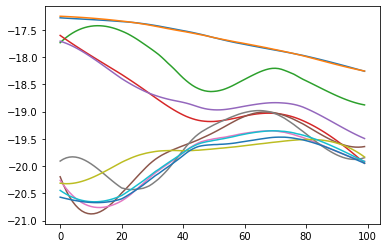

In [ ]:
for i in range(len(gen_data[2])):
  plt.plot(savgol_filter(gen_data[2][i].T,41,3))

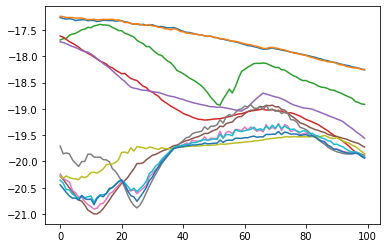

In [ ]:
for i in range(len(gen_data[2])):
  plt.plot(gen_data[2][i].T)

In [ ]:
plot_data = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster1.csv', delimiter = ',', skiprows = 1)
plot_data = plot_data.T[1:]
plot_data.shape
plot_data2 = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster3.csv', delimiter = ',', skiprows = 1)
plot_data2 = plot_data2.T[1:]
plot_data2.shape

(100, 9)

#Plotting graphs

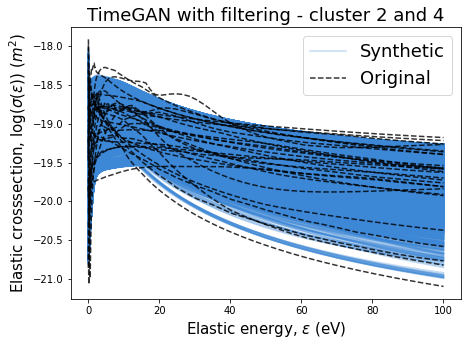

In [ ]:
plt.figure(figsize = [7,5])
for i in range(500):
  for j in range(len(gen_data[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data[i][j].T,51,3),  '#3c87d6', alpha = 0.3)

plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data[60][0].T,41,3),  '#3c87d6', alpha = 0.3, label='Synthetic')

for i in range(10):
  for j in range(len(gen_data_r[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data_r[i][j].T,51,3),  '#3c87d6', alpha = 0.3)
# for i in range(5):
#   plt.plot(list(df['elastic.energy'][0]),gen_data_r[i].T,  '#3c87d6', alpha = 0.3)
# plt.plot(list(df['elastic.energy'][0]),gen_data_r[60][0].T,  '#3c87d6', alpha = 0.3)

for i in range(len(plot_data.T)-2):
    plt.plot(list(df['elastic.energy'][0]), plot_data.T[i], color='k', ls = '--', alpha = 0.8)

plt.plot(list(df['elastic.energy'][0]),plot_data.T[-1],color='k', ls = '--', alpha = 0.8, label = 'Original')

for i in range(len(plot_data2.T)):
    plt.plot(list(df['elastic.energy'][0]), plot_data2.T[i], color='k', ls = '--', alpha = 0.8)

plt.legend(fontsize = 18)
plt.xlabel('Elastic energy, $\epsilon$ (eV)', fontsize = 15)
plt.ylabel(r'Elastic crosssection, log($\sigma$($\epsilon$)) ($m^{2}$)', fontsize = 15)
plt.title('TimeGAN with filtering - cluster 2 and 4', fontsize = 18)
plt.show()

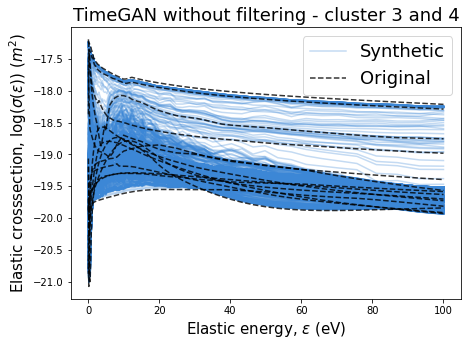

In [ ]:
plt.figure(figsize = [7,5])
for i in range(50):
  for j in range(len(gen_data[i])):
    plt.plot(list(df['elastic.energy'][0]),gen_data[i][j].T,  '#3c87d6', alpha = 0.3)

plt.plot(list(df['elastic.energy'][0]),gen_data[60][0].T,  '#3c87d6', alpha = 0.3, label='Synthetic')

for i in range(50):
  for j in range(len(gen_data_r[i])):
    plt.plot(list(df['elastic.energy'][0]),gen_data_r[i][j].T,  '#3c87d6', alpha = 0.3)
# for i in range(5):
#   plt.plot(list(df['elastic.energy'][0]),gen_data_r[i].T,  '#3c87d6', alpha = 0.3)
# plt.plot(list(df['elastic.energy'][0]),gen_data_r[60][0].T,  '#3c87d6', alpha = 0.3)

for i in range(len(plot_data.T)-2):
    plt.plot(list(df['elastic.energy'][0]), plot_data.T[i], color='k', ls = '--', alpha = 0.8)

plt.plot(list(df['elastic.energy'][0]),plot_data.T[-1],color='k', ls = '--', alpha = 0.8, label = 'Original')

for i in range(len(plot_data2.T)):
    plt.plot(list(df['elastic.energy'][0]), plot_data2.T[i], color='k', ls = '--', alpha = 0.8)

plt.legend(fontsize = 18)
plt.xlabel('Elastic energy, $\epsilon$ (eV)', fontsize = 15)
plt.ylabel(r'Elastic crosssection, log($\sigma$($\epsilon$)) ($m^{2}$)', fontsize = 15)
plt.title('TimeGAN without filtering - cluster 3 and 4', fontsize = 18)
plt.show()

# Saving data

In [ ]:
gen_data.shape

(505, 20, 100)

In [ ]:
gen_arr = gen_data.reshape(gen_data.shape[0]*gen_data.shape[1],gen_data.shape[2])

In [ ]:
gen_arr.shape

(10100, 100)

In [ ]:
np.savetxt('gen_data_c2_c4', gen_arr ,delimiter=',')

In [ ]:
gen_data_r.shape

(505, 20, 100)

In [ ]:
gen_arr_r = gen_data_r.reshape(gen_data_r.shape[0]*gen_data_r.shape[1],gen_data_r.shape[2])

In [ ]:
gen_arr_r.shape

(10100, 100)

In [ ]:
np.savetxt('gen_data_r_c2_c4', gen_arr_r ,delimiter=',')

# Combined clusters

In [ ]:
plot_data = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster2.csv', delimiter = ',', skiprows = 1)
plot_data = plot_data.T[1:]
plot_data2 = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster3.csv', delimiter = ',', skiprows = 1)
plot_data2 = plot_data2.T[1:]
plot_data0 = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster0.csv', delimiter = ',', skiprows = 1)
plot_data0 = plot_data0.T[1:]
plot_data1 = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster1.csv', delimiter = ',', skiprows = 1)
plot_data1 = plot_data1.T[1:]

In [ ]:
gen_data0 = np.loadtxt('/content/gdrive/Shareddrives/BMP/TimeGAN_new/Generated data/gen_data_c0', delimiter = ',')
gen_data0 = gen_data0.reshape(255,6,100)
gen_data1 = np.loadtxt('/content/gdrive/Shareddrives/BMP/TimeGAN_new/Generated data/gen_data_r_c0', delimiter = ',')
gen_data1 = gen_data1.reshape(255,6,100)

gen_data2 = np.loadtxt('/content/gdrive/Shareddrives/BMP/TimeGAN_new/Generated data/gen_data_c1', delimiter = ',')
gen_data2 = gen_data2.reshape(255,12,100)
gen_data3 = np.loadtxt('/content/gdrive/Shareddrives/BMP/TimeGAN_new/Generated data/gen_data_r_c1', delimiter = ',')
gen_data3 = gen_data3.reshape(255,12,100)

gen_data4 = np.loadtxt('/content/gdrive/Shareddrives/BMP/TimeGAN_new/Generated data/gen_data_c2', delimiter = ',')
gen_data4 = gen_data4.reshape(255,11,100)
gen_data5 = np.loadtxt('/content/gdrive/Shareddrives/BMP/TimeGAN_new/Generated data/gen_data_r_c2', delimiter = ',')
gen_data5 = gen_data5.reshape(255,11,100)

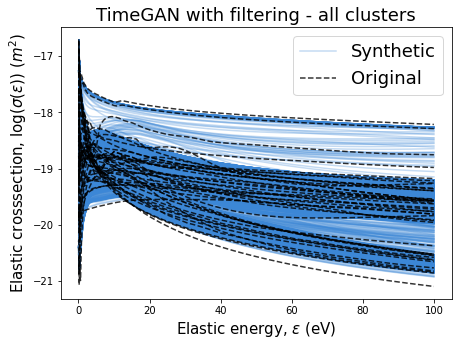

In [ ]:
plt.figure(figsize = [7,5])
for i in range(50):
  for j in range(len(gen_data0[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data0[i][j].T,51,3),  '#3c87d6', alpha = 0.3)
  for j in range(len(gen_data1[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data1[i][j].T,51,3),  '#3c87d6', alpha = 0.3)
  for j in range(len(gen_data2[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data2[i][j].T,51,3),  '#3c87d6', alpha = 0.3)
  for j in range(len(gen_data3[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data3[i][j].T,51,3),  '#3c87d6', alpha = 0.3)
  for j in range(len(gen_data4[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data4[i][j].T,51,3),  '#3c87d6', alpha = 0.3)
  for j in range(len(gen_data5[i])):
    plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data5[i][j].T,51,3),  '#3c87d6', alpha = 0.3)

plt.plot(list(df['elastic.energy'][0]),savgol_filter(gen_data0[60][0].T,41,3),  '#3c87d6', alpha = 0.3, label='Synthetic')



for i in range(len(plot_data.T)-2):
    plt.plot(list(df['elastic.energy'][0]), plot_data.T[i], color='k', ls = '--', alpha = 0.8)

plt.plot(list(df['elastic.energy'][0]),plot_data.T[-1],color='k', ls = '--', alpha = 0.8, label = 'Original')

for i in range(len(plot_data2.T)):
    plt.plot(list(df['elastic.energy'][0]), plot_data2.T[i], color='k', ls = '--', alpha = 0.8)
for i in range(len(plot_data0.T)):
    plt.plot(list(df['elastic.energy'][0]), plot_data0.T[i], color='k', ls = '--', alpha = 0.8)
for i in range(len(plot_data1.T)):
    plt.plot(list(df['elastic.energy'][0]), plot_data1.T[i], color='k', ls = '--', alpha = 0.8)

plt.legend(fontsize = 18)
plt.xlabel('Elastic energy, $\epsilon$ (eV)', fontsize = 15)
plt.ylabel(r'Elastic crosssection, log($\sigma$($\epsilon$)) ($m^{2}$)', fontsize = 15)
plt.title('TimeGAN with filtering - all clusters', fontsize = 18)
plt.show()

# Evaluation using PCA and t-sne

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

stock_data = np.append(plot_data0 , plot_data)
stock_data = np.append(stock_data, plot_data1)
stock_data = np.append(stock_data, plot_data2)
synth_data = np.append(gen_data0.reshape(255*6,100),gen_data1.reshape(255*6,100),axis=0)
synth_data = np.append(synth_data,gen_data2.reshape(255*12,100),axis=0)
synth_data = np.append(synth_data,gen_data3.reshape(255*12,100),axis=0)
synth_data = np.append(synth_data,gen_data4.reshape(255*11,100),axis=0)
synth_data = np.append(synth_data, gen_data5.reshape(255*11,100),axis=0)
synth_data = savgol_filter(synth_data,51,3)
sample_size = 246
seq_len =100
idx = np.random.permutation(len(synth_data))[:sample_size]

# real_sample = np.asarray(stock_data)
synthetic_sample = np.asarray(synth_data)[idx]
print(stock_data.shape, synthetic_sample.shape)
#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
# synth_data_reduced = real_sample.reshape(-1, seq_len)
real_data= np.asarray(stock_data.reshape(-1,100))
synth_data_reduced = np.asarray(synthetic_sample)
print(real_data.shape,synth_data_reduced.shape)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(real_data)

pca_real = pd.DataFrame(pca.transform(real_data))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

(4600,) (246, 100)
(46, 100) (246, 100)


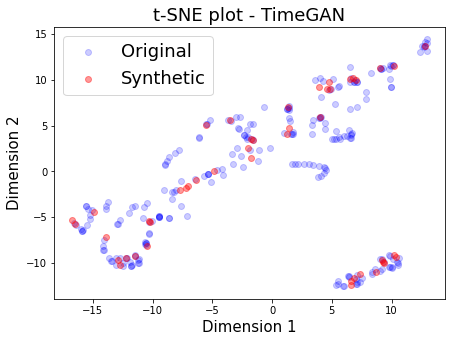

In [ ]:
#The scatter plots for PCA and TSNE methods
# import matplotlib.gridspec as gridspec
# fig = plt.figure(constrained_layout=True)
# spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# #TSNE scatter plot
# ax = fig.add_subplot(spec[0,0])
# ax.set_title('PCA results',
#              fontsize=20,
#              color='red',
#              pad=10)

# #PCA scatter plot
# plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
#             c='black', alpha=0.2, label='Original')
# plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
#             c='red', alpha=0.2, label='Synthetic')
# ax.legend()

# ax2 = fig.add_subplot(spec[0,1])
# ax2.set_title('TSNE results',
#               fontsize=20,
#               color='red',
#               pad=10)


plt.figure(figsize = [7,5])
plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='blue', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.4, label='Synthetic')
plt.legend(fontsize = 18)
plt.xlabel('Dimension 1', fontsize = 15)
plt.ylabel(r'Dimension 2', fontsize = 15)
plt.title('t-SNE plot - TimeGAN', fontsize = 18)
plt.show()



## For TGAN 

In [ ]:
## Synthetic data
df_syn_1 = pd.read_csv('/content/gdrive/Shareddrives/BMP/generated_data/TGAN/data_output_c{}.csv'.format(0)).T
df_syn_2 = pd.read_csv('/content/gdrive/Shareddrives/BMP/generated_data/TGAN/data_output_c{}.csv'.format(1)).T
df_syn_3 = pd.read_csv('/content/gdrive/Shareddrives/BMP/generated_data/TGAN/data_output_c{}.csv'.format(2)).T
df_syn_4 = pd.read_csv('/content/gdrive/Shareddrives/BMP/generated_data/TGAN/data_output_c{}.csv'.format(3)).T

In [ ]:
## Real data
df_1 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster{}.csv'.format(0)).drop(['Unnamed: 0'], axis = 1)
df_2 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster{}.csv'.format(1)).drop(['Unnamed: 0'], axis = 1)
df_3 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster{}.csv'.format(2)).drop(['Unnamed: 0'], axis = 1)
df_4 = pd.read_csv('/content/gdrive/Shareddrives/BMP/data/cluster{}.csv'.format(3)).drop(['Unnamed: 0'], axis = 1)

In [ ]:
df_synth = pd.concat([df_syn_1, df_syn_2, df_syn_3, df_syn_4])
df_real = pd.concat([df_1, df_2, df_3, df_4])
df_real.shape

(46, 100)

In [ ]:
df_synth.shape

(40000, 100)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# stock_data = np.append(plot_data0 , plot_data)
# stock_data = np.append(stock_data, plot_data1)
stock_data = np.array(df_real)
synth_data = np.array(df_synth)
# synth_data = np.append(gen_data0.reshape(255*6,100),gen_data1.reshape(255*6,100),axis=0)
# synth_data = np.append(synth_data,gen_data2.reshape(255*12,100),axis=0)
# synth_data = np.append(synth_data,gen_data3.reshape(255*12,100),axis=0)
# synth_data = np.append(synth_data,gen_data4.reshape(255*11,100),axis=0)
# synth_data = np.append(synth_data, gen_data5.reshape(255*11,100),axis=0)

sample_size = 246
seq_len =100
idx = np.random.permutation(len(synth_data))[:sample_size]

# real_sample = np.asarray(stock_data)
synthetic_sample = np.asarray(synth_data)[idx]
print(stock_data.shape, synthetic_sample.shape)
#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
# synth_data_reduced = real_sample.reshape(-1, seq_len)
real_data= np.asarray(stock_data.reshape(-1,100))
synth_data_reduced = np.asarray(synthetic_sample)
print(real_data.shape,synth_data_reduced.shape)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(real_data)

pca_real = pd.DataFrame(pca.transform(real_data))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(real_data)

NameError: ignored

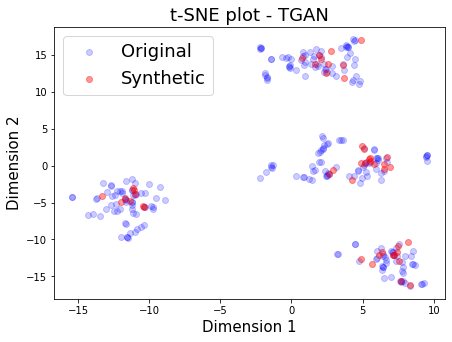

In [ ]:
#The scatter plots for PCA and TSNE methods
# import matplotlib.gridspec as gridspec
# fig = plt.figure(constrained_layout=True)
# spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# #TSNE scatter plot
# ax = fig.add_subplot(spec[0,0])
# ax.set_title('PCA results',
#              fontsize=20,
#              color='red',
#              pad=10)

# #PCA scatter plot
# plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
#             c='black', alpha=0.2, label='Original')
# plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
#             c='red', alpha=0.2, label='Synthetic')
# ax.legend()

# ax2 = fig.add_subplot(spec[0,1])
# ax2.set_title('TSNE results',
#               fontsize=20,
#               color='red',
#               pad=10)


plt.figure(figsize = [7,5])
plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='blue', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.4, label='Synthetic')
plt.legend(fontsize = 18)
plt.xlabel('Dimension 1', fontsize = 15)
plt.ylabel(r'Dimension 2', fontsize = 15)
plt.title('t-SNE plot - TGAN', fontsize = 18)
plt.show()



# Train synthetic test real (TSTR)

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [ ]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

In [ ]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

In [ ]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

In [ ]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

# Useless code

In [ ]:
# from scipy.signal import savgol_filter
# for i in range(gen_data.shape[0]-2):
#   plt.plot(gen_data[i].T,'b')
#   # plt.plot(butter_lowpass_filter(e, cutoff, fs, order), 'b')
# plt.plot(gen_data[0][0].T, 'b', label = 'Synthetic')
# plt.plot(plot_data[:-1], 'r', alpha = 0.8)
# plt.plot(plot_data.T[-1], 'r', label = 'Original')
# plt.legend()
# plt.title('Synthetic data for cluster 0 after filtering using Savgol filter')
# plt.show()

In [ ]:
# gen_arr = np.zeros([len(gen_data[0][0]),100])
# print(gen_arr[0])
# for i in range(0, 91, 10):
#   print('i',i)
#   j = 0
#   for data in gen_data[i].T:
#     #print('col',j)
#     # print(data.shape)
#     # print(data)
#     #print(gen_arr[j][i:i+10].shape)
#     gen_arr[j][i:i+10] = data
#     j = j + 1

In [ ]:
# from scipy.signal import savgol_filter
# for e in gen_arr[:-2]:
#   plt.plot(savgol_filter(e,51, 2),'b')
#   # plt.plot(butter_lowpass_filter(e, cutoff, fs, order), 'b')
# plt.plot(savgol_filter(gen_arr[-1], 51,2), 'b', label = 'Synthetic')
# plt.plot(plot_data[:-1], 'r', alpha = 0.8)
# plt.plot(plot_data.T[-1], 'r', label = 'Original')
# plt.legend()
# plt.title('Synthetic data for cluster 0 after filtering using Savgol filter')
# plt.show()

In [ ]:
# ##plt.plot(x1, label = 'Real')
# for i in range(len(gen_data[0].T)-1):
#     plt.plot(ee[:-1], x2[0].T[i], color='b', alpha = 0.8)
# plt.plot(ee[:-1], x2[0].T[len(x2[0].T)-1], label = 'Synthetic', color='b', alpha = 0.8)
# for i in range(len(clusters[cluster])-1):
#     plt.plot(ee, clusters[cluster][i], color='r', ls = '-.', alpha = 0.6)
# plt.plot(ee, clusters[cluster][len(clusters[cluster])-1], label = 'Original', color='r', alpha = 0.6, ls = '-.')
# plt.xlim([1e-1, 1e2])
# plt.legend()
# plt.savefig('fig1.png')a

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# energy_data = data_3D
# synth_data = gen_data

# sample_size = 250
# idx = np.random.permutation(len(energy_data))[:sample_size]

# # Convert list to array, but taking only 250 random samples
# # energy_data: (list(19711(ndarray(24, 28)))) -> real_sample: ndarray(250, 24, 28)
# real_sample = np.asarray(energy_data)[idx]
# synthetic_sample = np.asarray(synth_data)[idx]

# # For the purpose of comparison we need the data to be 2-Dimensional.
# # For that reason we are going to use only two components for both the PCA and TSNE.
# # synth_data_reduced: {ndarray: (7000, 24)}
# # energy_data_reduced: {ndarray: (7000, 24)}
# synth_data_reduced = real_sample.reshape(-1, seq_len)
# energy_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

# n_components = 2
# pca = PCA(n_components=n_components)
# tsne = TSNE(n_components=n_components, n_iter=300)

# # The fit of the methods must be done only using the real sequential data
# pca.fit(energy_data_reduced)

# # pca_real: {DataFrame: (7000, 2)}
# # pca_synth: {DataFrame: (7000, 2)}
# pca_real = pd.DataFrame(pca.transform(energy_data_reduced))
# pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

# # data_reduced: {ndarray: (14000, 24)}
# data_reduced = np.concatenate((energy_data_reduced, synth_data_reduced), axis=0)

# # tsne_results: {DataFrame: (14000, 2)}
# tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

In [ ]:
# import matplotlib.pyplot as plt
# plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
#             c='black', alpha=0.2, label='Original')

In [ ]:
# # Scatter plots for PCA and t-SNE methods




# fig = plt.figure(constrained_layout=True, figsize=(20, 10))


# ax = fig.add_subplot(spec[0,0])
# ax.set_title('PCA results',
#              fontsize=20,
#              color='red',
#              pad=10)

# # PCA scatter plot

# plt.xlim(-1.5, 1.5)
# plt.ylim(-1.5, 1.5)

# plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
#             c='red', alpha=0.2, label='Synthetic')
# plt.xlim(-1.5, 1.5)
# plt.ylim(-1.5, 1.5)

# ax.legend()

# ax2 = fig.add_subplot(spec[0,1])
# ax2.set_title('TSNE results',
#               fontsize=20,
#               color='red',
#               pad=10)

# # t-SNE scatter plot
# plt.scatter(tsne_results.iloc[:7000, 0].values, tsne_results.iloc[:7000, 1].values,
#             c='black', alpha=0.2, label='Original')
# plt.scatter(tsne_results.iloc[7000:, 0], tsne_results.iloc[7000:, 1],
#             c='red', alpha=0.2, label='Synthetic')

# # ax2.legend()

# # fig.suptitle('Validating synthetic vs real data diversity and distributions',
# #              fontsize=16,
# #              color='grey')


# # plt.savefig('synthetic_vs_real_data_diversity_and_distributions.png', dpi=200)

## TGAN Model 

In [ ]:
from tgan.model import TGANModel

### Training

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
def tgan_fit(tgan, df_1):
  with tf.device('/device:GPU:0'):
    tgan.fit(df_1)
    return tgan

In [ ]:
for i, cluster in enumerate(clusters):
    
    df_1 = pd.DataFrame(cluster)
    cols = df_1.columns

    # columns with continuous values
    continuous_columns = np.arange(1,len(df_ip.columns)+1,1)
    tgan = TGANModel(continuous_columns, batch_size = 2, max_epoch = 10, steps_per_epoch = 1000, learning_rate=0.001)
    tgan = tgan_fit(tgan, df_1)

    # generating synthetic samples
    syn_data = tgan.sample(10000)
    syn_data = syn_data.T
    syn_data = syn_data.astype(np.float16)

    # plot 
    
    plt.figure(figsize = [12,8])
    for i in range(len(syn_data.columns)-1):
        plt.plot(list(df['elastic.energy'][0]), butter_lowpass_filter(syn_data[i], cutoff, fs, order), 'b', alpha = 0.3)
    
    plt.plot(list(df['elastic.energy'][0]), butter_lowpass_filter(syn_data[len(syn_data.columns)-1], cutoff, fs, order), color='b', label = 'Synthetic')
    
    
    for i in range(len(clusters[cluster])-1):
        plt.plot(list(df['elastic.energy'][0]), clusters[cluster][i], color='r', ls = '-.', alpha = 0.8)
    plt.plot(list(df['elastic.energy'][0]), clusters[cluster][-1], color='r', ls = '-.', alpha = 0.8, label='Original')
    
    # plt.xlim([1e-1, 1e2])
    plt.legend()
    plt.title('TGAN with filtering - data for cluster {}'.format(i))
    plt.savefig('TGAN_filtered_10000_cluster{}.png'.format{})


### Saving the model

In [ ]:
model_path = 'models/tgan.pkl'

In [ ]:
tgan.save(model_path)

### Generating synthetic samples

In [ ]:
# Butterworth filter 
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [ ]:
##plt.plot(x1, label = 'Real')
plt.figure(figsize = [12,8])
for i in range(len(syn_data.columns)-1):
    plt.plot(list(df['elastic.energy'][0]), butter_lowpass_filter(syn_data[i], cutoff, fs, order), 'b', alpha = 0.3)
    #plt.plot(savgol_filter(syn_data[i], 61, 3), color='b')
plt.plot(list(df['elastic.energy'][0]), butter_lowpass_filter(syn_data[len(syn_data.columns)-1], cutoff, fs, order), color='b', label = 'Synthetic')
#plt.show()
# plt.plot(ee[:-1], x2[0].T[len(x2[0].T)-1], label = 'Synthetic', color='b', alpha = 0.8)
for i in range(len(clusters[cluster])-1):
    plt.plot(list(df['elastic.energy'][0]), clusters[cluster][i], color='r', ls = '-.', alpha = 0.8)
plt.plot(list(df['elastic.energy'][0]), clusters[cluster][-1], color='r', ls = '-.', alpha = 0.8, label='Original')
# plt.plot(ee, clusters[cluster][len(clusters[cluster])-1], label = 'Original', color='r', alpha = 0.6, ls = '-.')
# plt.xlim([1e-1, 1e2])
plt.legend()
plt.title('TGAN with filtering')
plt.savefig('fig1.png')

In [ ]:
pd.DataFrame(syn_data).to_csv('data_output.csv', index = False)

In [ ]:
plot_data = np.loadtxt('/content/gdrive/Shareddrives/BMP/data/cluster0.csv', delimiter = ',', skiprows = 1)
plot_data = plot_data.T[1:]
plot_data.shape

(100, 11)

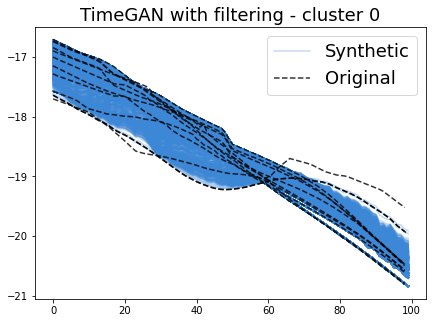

In [ ]:
plt.figure(figsize = [7,5])
for i in range(500):
  plt.plot(list(df['elastic.energy'][0]),gen_data[i].T,  '#3c87d6', alpha = 0.3)
plt.plot(list(df['elastic.energy'][0]),gen_data[600][0].T,  '#3c87d6', alpha = 0.3, label='Synthetic')
plt.plot(list(df['elastic.energy'][0]),plot_data[:-1], color='k', ls = '--', alpha = 0.8)
plt.plot(list(df['elastic.energy'][0]),plot_data.T[-1],color='k', ls = '--', alpha = 0.8, label = 'Original')
plt.legend(fontsize = 18)
plt.xlabel('Elastic energy, $\epsilon$ (eV)', fontsize = 15)
plt.ylabel(r'Elastic crosssection, log($\sigma$($\epsilon$)) ($m^{2}$)', fontsize = 15)
plt.title('TimeGAN with filtering - cluster 0', fontsize = 18)
plt.show()
